# 차선인식

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Lane Finding (white lane)

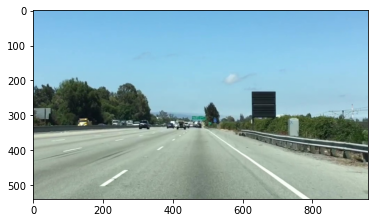

In [3]:
image = mpimg.imread('./data/test.jpg')
plt.imshow(image)

## Color Selection 

Color Picker Tool로 해당 이미지 색상의 RGB 코드값 얻어오기
https://annystudio.com/software/colorpicker/#download

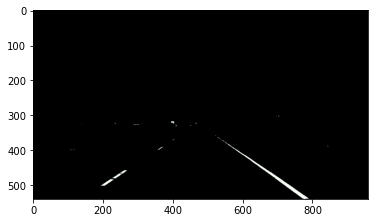

In [4]:
color_select = np.copy(image)

red_threshold = 237
green_threshold = 237
blue_threshold = 237


color_threshold = ((image[:, :, 0] < red_threshold) |
                   (image[:, :, 1] < green_threshold) |
                   (image[:, :, 2] < blue_threshold))

color_select[color_threshold] = [0, 0, 0]
plt.imshow(color_select)

## Region Selection

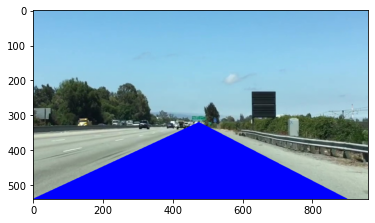

In [10]:
region_select = np.copy(image)

# todo
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]

pts = np.array([left_bottom, right_bottom, apex])
cv2.fillPoly(region_select, [pts], color=[0, 0, 255])
plt.imshow(region_select)

## Color and Region Selection

In [5]:
image.shape

(540, 960, 3)

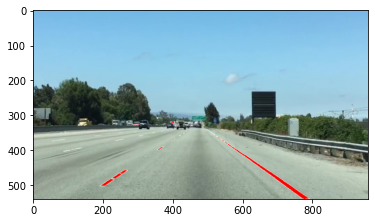

In [6]:
color_select = np.copy(image)

red_threshold = 237
green_threshold = 237
blue_threshold = 237


color_threshold = ((image[:, :, 0] < red_threshold) |
                   (image[:, :, 1] < green_threshold) |
                   (image[:, :, 2] < blue_threshold))

color_select[color_threshold] = [0, 0, 0]

# 2. Region Selection
region_select = np.copy(image)

left_button = [0, 540]
right_button = [960, 540]
apex = [475, 330]

pts = np.array([left_button, right_button, apex])
cv2.fillPoly(region_select, [pts], color = [0, 0, 255])

region_threshold = ((region_select[:, :, 0] == 0) &    # R channel
                    (region_select[:, :, 1] == 0) &    # G channel
                    (region_select[:, :, 2] == 255))   # B channel


# 3 Color Selection + Region Selection
# color_threshold: 차선(흰색)이 아닌 부분 True 설정
# region_threshold: 관심영역(region of interes, roi)에만 True 설정
lane_select = np.copy(image)
lane_select[~color_threshold > 0] = [255, 0, 0]

plt.imshow(lane_select)

In [7]:
~color_threshold

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## 2. Lane Finding (white and yellow)

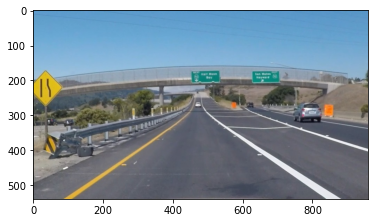

In [11]:
image = mpimg.imread('./data/exit-ramp.jpg')
plt.imshow(image)

### Step 1: gray scale 변환

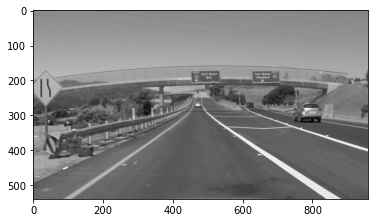

In [17]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

### Step 2: Gaussian blurring (option)

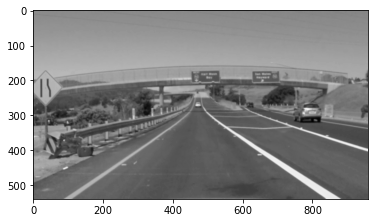

In [18]:
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
plt.imshow(blur_gray, cmap='gray')

## ROI Selection

### Step 3: edge detect

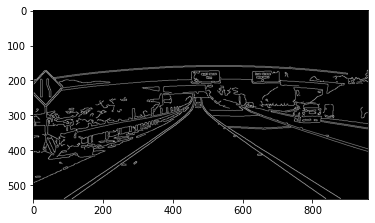

In [34]:
low_threshold = 50
high_threshold = 150  # low:high의 비율 1:2 or 1:3
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

### Step 4: roi selection (region of interest)

In [25]:
edges.shape

(540, 960)

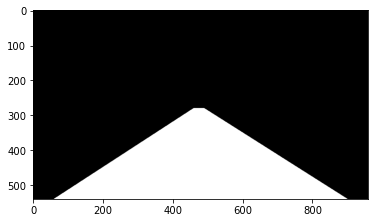

In [47]:
pts = np.array([[60, 539], [900, 539], [490, 280], [460, 280]])
mask = np.zeros(edges.shape, edges.dtype)
cv2.fillPoly(mask, [pts], color=[255, 255, 255])
plt.imshow(mask, cmap='gray')

In [41]:
height = edges.shape[0]
width = edges.shape[1]

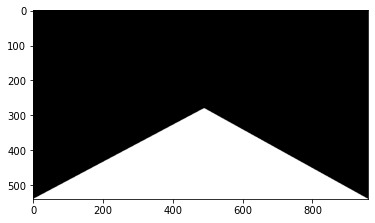

In [46]:
# 관심 영역의 mask 준비

pts = np.array([[0, height - 1], [1, 539], [490, 280], [width - 1, height - 1]])
mask = np.zeros(edges.shape, edges.dtype)
cv2.fillPoly(mask, [pts], color=[255, 255, 255])
plt.imshow(mask, cmap='gray')

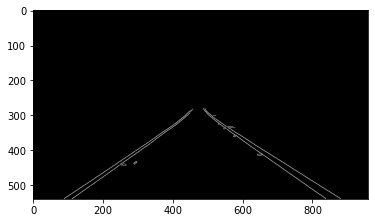

In [49]:
# 위에서 준비한 mask와 edges를 bitwise_and
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges, cmap='gray')

### Step 5: line detect (with hough transform)

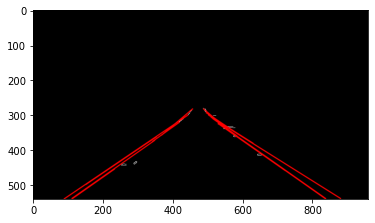

In [76]:
rho = 1
theta = np.pi / 180
threshold = 35
minLineLength = 40
maxLineGap = 50

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold,
                        minLineLength=minLineLength, maxLineGap=maxLineGap)

# (참고) 1차원 데이터를 3차원으로 확장하는 방법
# dst = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR)  # 직선을 그릴 도화지 (3 채널 도화지)  option 1
# dst = cv2.merge([masked_edges, masked_edges, masked_edges]) option 2
# dst = np.dstack((masked_edges, masked_edges, masked_edges)) option 3
dst = np.dstack((masked_edges, masked_edges, masked_edges))

if lines is not None:
    for i in range(len(lines)):
        line = lines[i][0]
        pt1 = line[0], line[1]
        pt2 = line[2], line[3]
        cv2.line(dst, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)
        
plt.imshow(dst)

## Pipeline (Step 1 ~ Step 5)
- Canny Detection -> ROI Selection -> Hough Transform

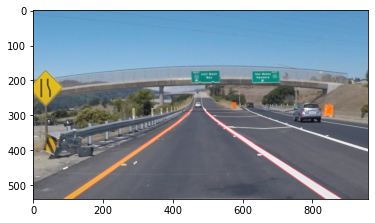

In [85]:
## Step 1: gray scale 변환

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)



## Step 2: Gaussian blurring (option)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)



# ROI Selection
## Step 3: edge detect

low_threshold = 50
high_threshold = 150  # low:high의 비율 1:2 or 1:3
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)



## Step 4: roi selection (region of interest)

pts = np.array([[60, 539], [900, 539], [490, 280], [460, 280]])
mask = np.zeros(edges.shape, edges.dtype)
cv2.fillPoly(mask, [pts], color=[255, 255, 255])
plt.imshow(mask, cmap='gray')

# 위에서 준비한 mask와 edges를 bitwise_and
masked_edges = cv2.bitwise_and(edges, mask)



## Step 5: line detect (with hough transform)

rho = 1
theta = np.pi / 180
threshold = 35
minLineLength = 40
maxLineGap = 50

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold,
                        minLineLength=minLineLength, maxLineGap=maxLineGap)

# (참고) 1차원 데이터를 3차원으로 확장하는 방법
# dst = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR)  # 직선을 그릴 도화지 (3 채널 도화지)  option 1
# dst = cv2.merge([masked_edges, masked_edges, masked_edges]) option 2
# dst = np.dstack((masked_edges, masked_edges, masked_edges)) option 3
dst = np.dstack((masked_edges, masked_edges, masked_edges))

if lines is not None:
    for i in range(len(lines)):
        line = lines[i][0]
        pt1 = line[0], line[1]
        pt2 = line[2], line[3]
        cv2.line(dst, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)

# result = cv2.add(image, dst)
result = cv2.addWeighted(image, 1, dst, 0.8, 0)   # 비중 조절 가능

plt.imshow(result)